# Quick model evaluation
Uses less users than full sampling to speed up the evaluation process.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import models
import mscthesis
import pipeline
import numpy as np
import validation
import plots
import pandas as pd
import geopandas as gpd

import plotly.graph_objects as go

In [171]:
geotweets = mscthesis.read_geotweets('sweden').set_index('userid')

tweetcount = geotweets.groupby('userid').size()
geotweets = geotweets.drop(labels=tweetcount[tweetcount < 20].index)

regioncount = geotweets.groupby(['userid', 'region']).size().groupby('userid').size()
geotweets = geotweets.drop(labels=regioncount[regioncount < 2].index)

# Should be sorted by createdat
geotweets = geotweets.sort_values(by=['userid', 'createdat'])

# Select small subset of users
#random_users = geotweets.index.get_level_values(level=0).unique()[:200]
#geotweets = geotweets.loc[random_users]

In [4]:
geotweets.groupby('userid').size()

userid
5616      2130
5976       287
8981       941
32213      413
392123     617
618063      87
625323     120
633523     458
641033     360
646913     896
dtype: int64

In [5]:
home_locations = pd.read_csv("./../../dbs/sweden/homelocations.csv").set_index('userid')
home_locations = gpd.GeoDataFrame(
    home_locations,
    crs="EPSG:3006",
    geometry=gpd.points_from_xy(home_locations.x, home_locations.y),
)

In [4]:
sampers = validation.Sampers()
sampers.prepare()

Preparing scale national
Reading original data...
zones (682, 2)
odm (595984,) 221892.04955949992
Reindexing...
odm (465124,)
Calculating distances between zones...
distances (465124,)
Calculating quantiles...

Preparing scale east
Reading original data...
zones (3038, 5)
odm (8791225,) 3339597.621275899
Reindexing...
odm (9229444,)
Calculating distances between zones...
distances (9229444,)
Calculating quantiles...

Preparing scale west
Reading original data...
zones (2964, 5)
odm (9253764,) 4982573.000714299
Reindexing...
odm (8785296,)
Calculating distances between zones...
distances (8785296,)
Calculating quantiles...



Text(-0.45, 0.5, 'B')

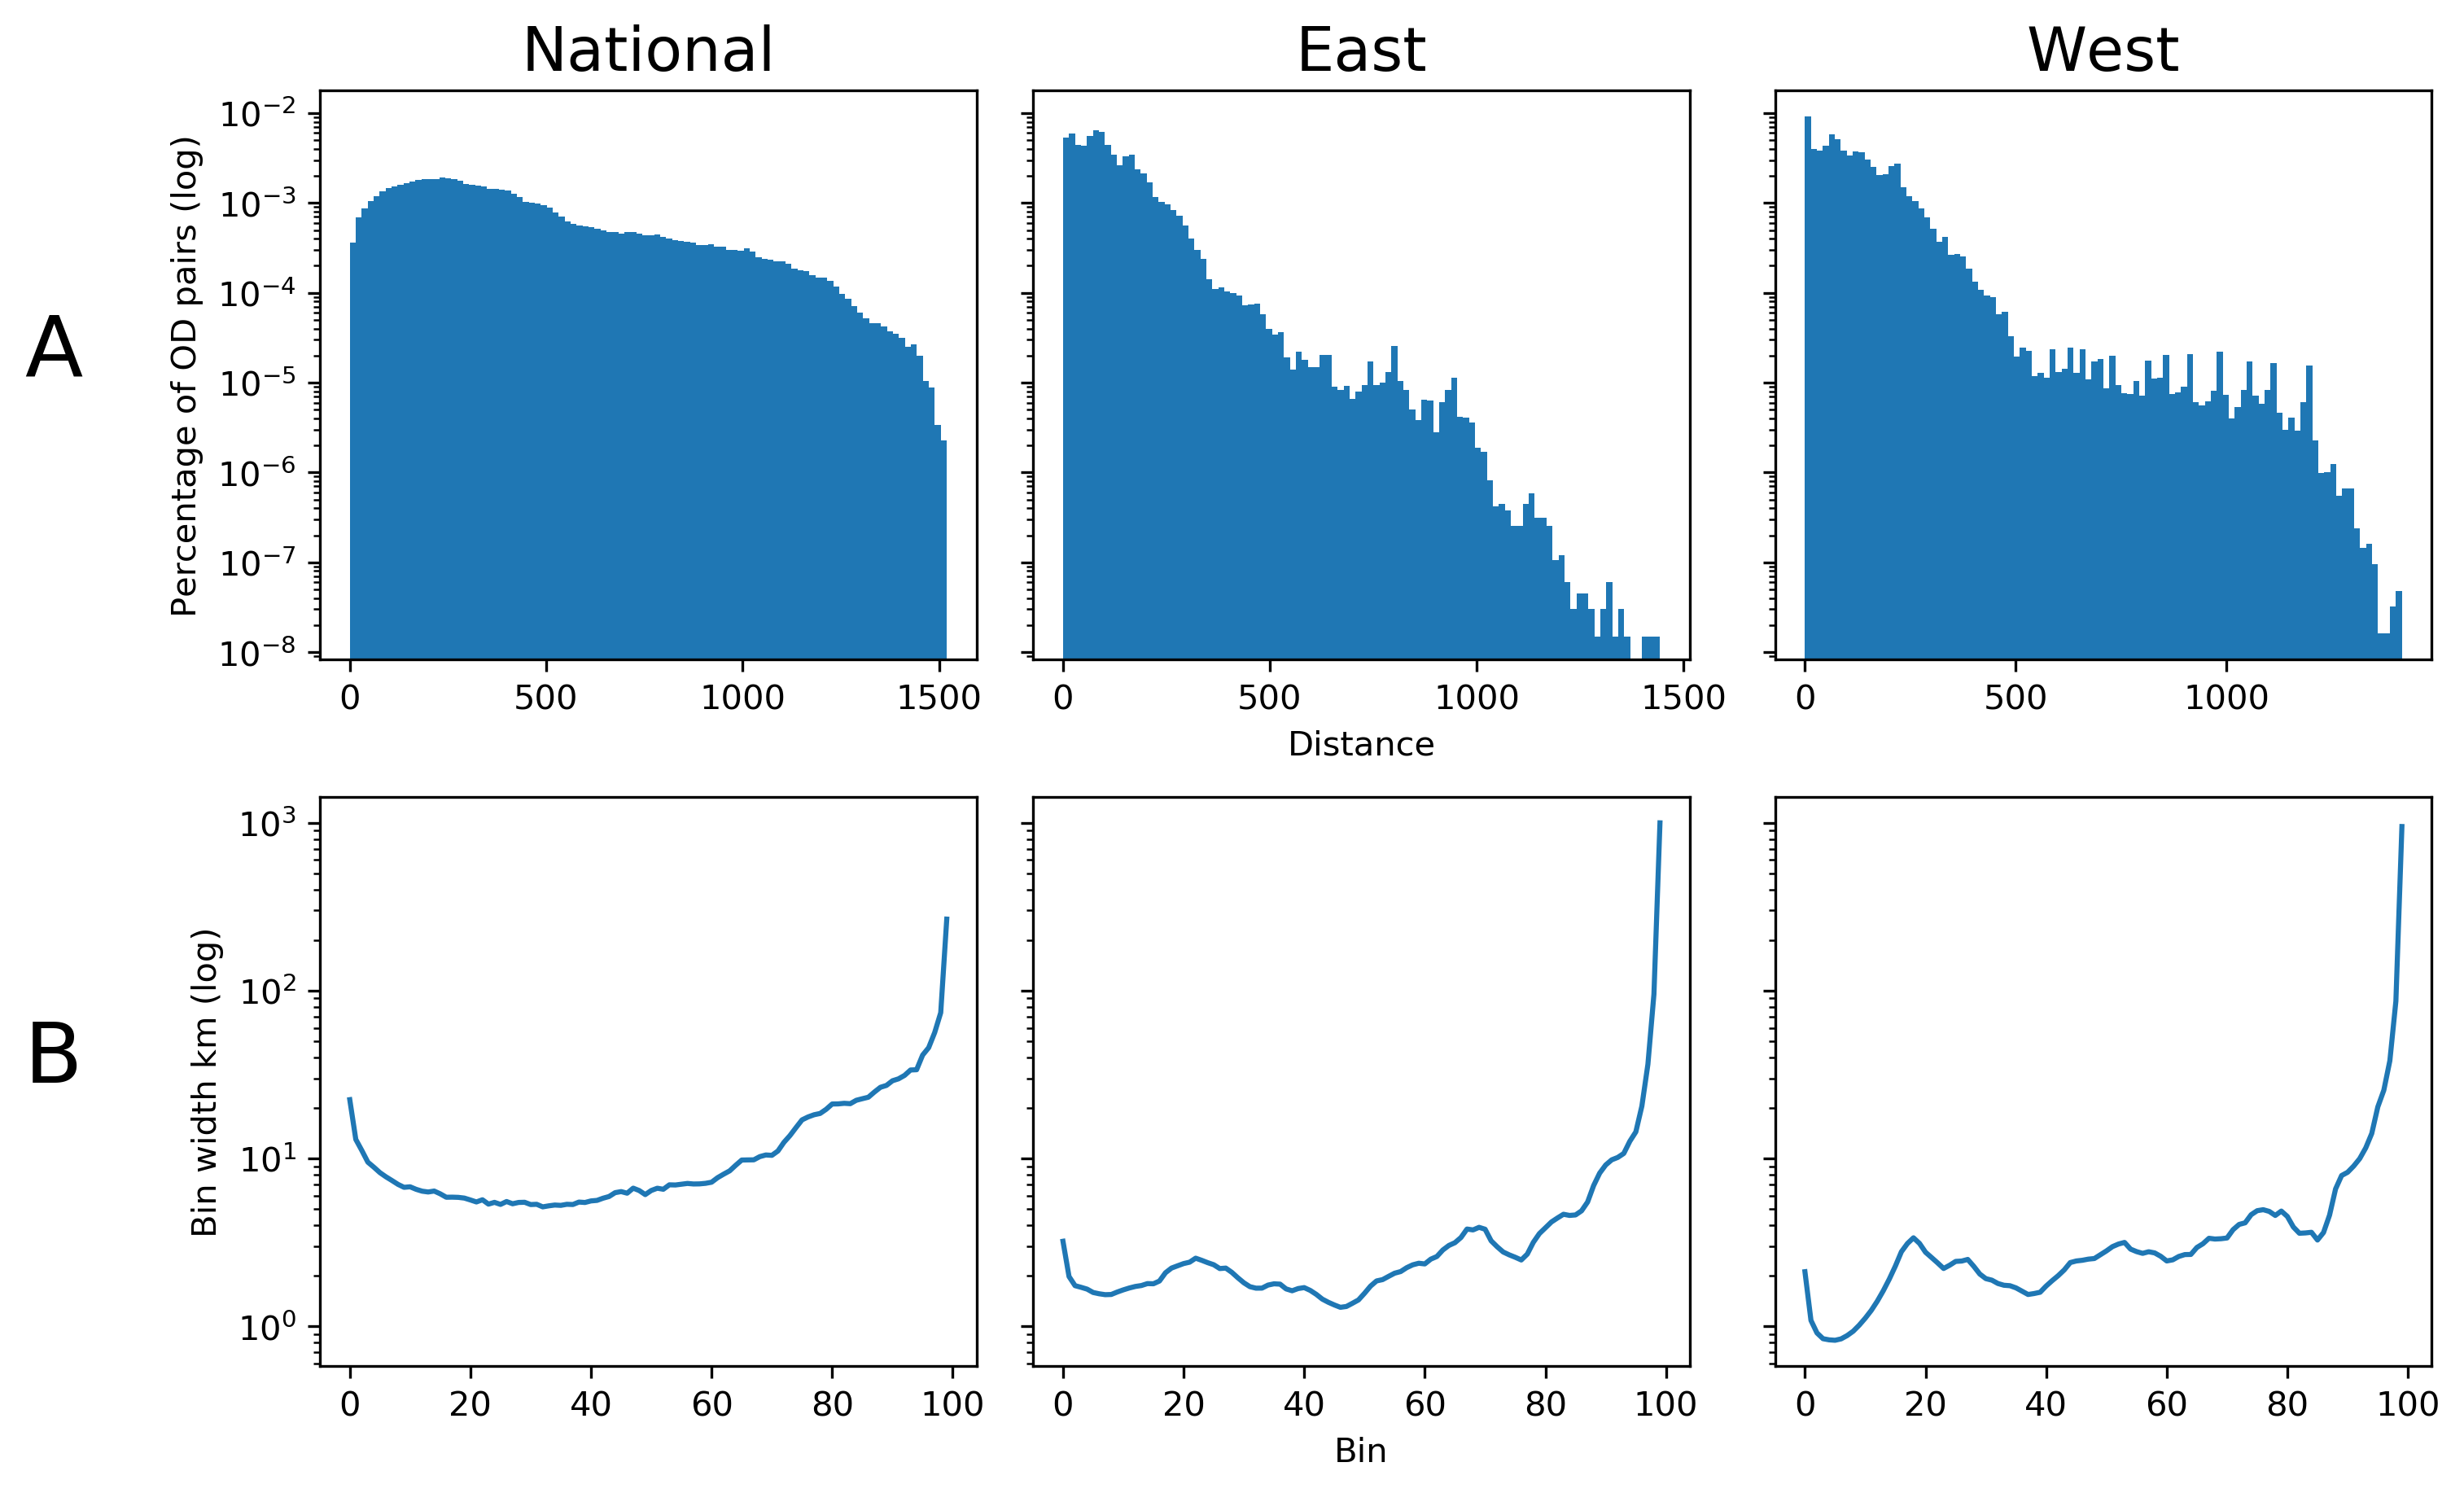

In [106]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,3, figsize=(10,6), constrained_layout=True, sharey='row')
for (axi, scale) in zip(range(0,len(axes[0])), ['national', 'east', 'west']):
    ax1 = axes[0,axi]

    ax1.set_title(scale.capitalize(), fontsize=18)
    sampers.distances[scale].hist(bins=100, ax=ax1, density=True, grid=False)
    ax1.set_yscale('log')
    
    ax2 = axes[1,axi]
    bin_sizes = pd.Series(pd.IntervalIndex(list(sampers.quantile_groups[scale].groups.keys())).length)
    bin_sizes.plot(ax=ax2, logy=True)
    
axes[0,0].set_ylabel('Percentage of OD pairs (log)', fontsize=10)
axes[0,1].set_xlabel('Distance', fontsize=10)
axes[1,0].set_ylabel('Bin width km (log)', fontsize=10)
axes[1,1].set_xlabel('Bin', fontsize=10)

axes[0,0].text(-0.45, .5, "A", transform=axes[0,0].transAxes, fontsize='25')
axes[1,0].text(-0.45, .5, "B", transform=axes[1,0].transAxes, fontsize='25')



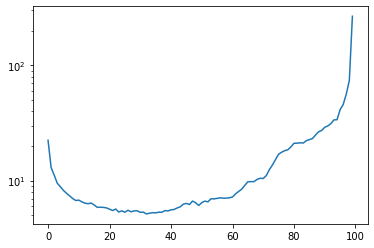

In [69]:
pd.Series(pd.IntervalIndex(list(sampers.quantile_groups['national'].groups.keys())).length).plot(logy=True)

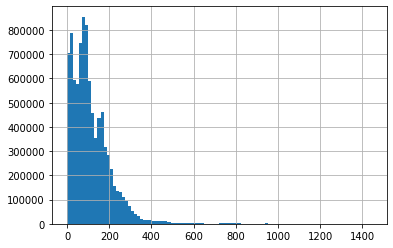

In [8]:
sampers.distances['east'].hist(bins=100)

In [23]:
for k,_ in sampers.quantile_groups['east']:
    print(k.right - k.left)

3.2119999999999997
1.9810000000000003
1.7469999999999999
1.7080000000000002
1.6660000000000004
1.5909999999999993
1.5630000000000006
1.5439999999999987
1.5480000000000018
1.600999999999999
1.649000000000001
1.6920000000000002
1.727999999999998
1.75
1.7970000000000006
1.7929999999999993
1.8620000000000019
2.086000000000002
2.2239999999999966
2.293999999999997
2.365000000000002
2.4110000000000014
2.546999999999997
2.4740000000000038
2.394999999999996
2.328000000000003
2.209000000000003
2.222999999999999
2.0970000000000013
1.945999999999998
1.8170000000000002
1.722999999999999
1.6879999999999953
1.6890000000000072
1.7609999999999957
1.7920000000000016
1.784000000000006
1.6709999999999923
1.6290000000000049
1.679000000000002
1.7009999999999934
1.6370000000000005
1.551000000000002
1.453000000000003
1.3909999999999911
1.3410000000000082
1.2980000000000018
1.3129999999999882
1.3719999999999999
1.436000000000007
1.5729999999999933
1.7360000000000042
1.8640000000000043
1.8979999999999961
1.9849

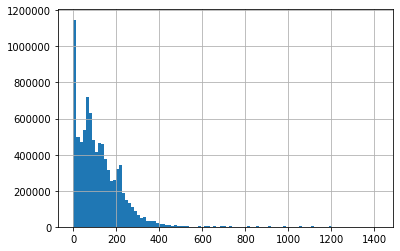

In [9]:
sampers.distances['west'].hist(bins=100)

In [172]:
sampler = models.Sampler(
    model=models.PreferentialReturn(
        p=0.66, 
        gamma=0.6, 
        region_sampling=models.RegionTransitionZipf(beta=0.05),
        jump_size_sampling=models.JumpSizeTrueProb(),
    ),
    n_days=7*20,
    daily_trips_sampling=models.NormalDistribution(mean=3.14, std=1.8),
    geotweets_path="",
)

In [173]:
sampler.describe()

{'model': {'p': 0.66,
  'gamma': 0.6,
  'region_sampling': {'name': 'transitionZipf', 'zipfs': 1.2, 'beta': 0.05},
  'jump_size_sampling': {'name': 'trueProb'}},
 'daily_trips_sampling': {'name': 'normal', 'mean': 3.14, 'std': 1.8},
 'n_days': 140,
 'geotweets_path': ''}

In [176]:
visits = sampler.sample(geotweets)

removed 2925 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 110 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
2797 visits left after alignment
removed 2076 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 731 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
3502 visits left after alignment
4.3526402099853404e-14


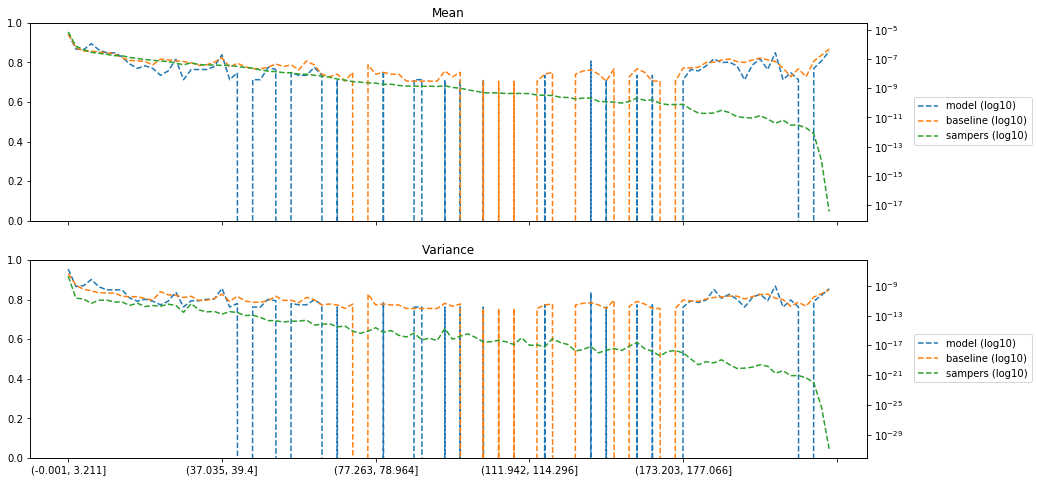

In [146]:
# National

removed 2868 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 3 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
2912 visits left after alignment
removed 2076 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 731 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
3502 visits left after alignment
2.5058751212475343e-14


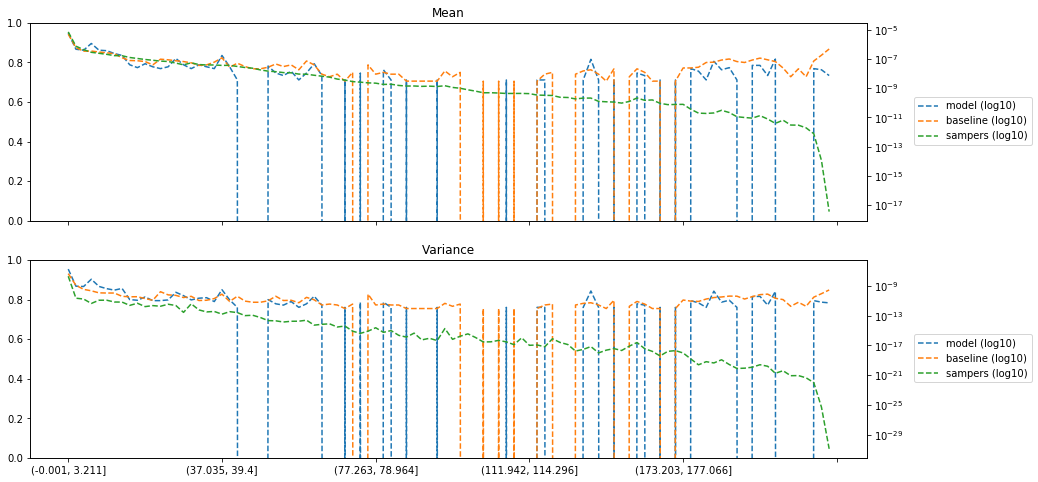

In [151]:
quick_eval("east", converted_visits, converted_baseline, home_locations, sampers)

removed 2959 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 0 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
3067 visits left after alignment
removed 2076 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 731 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
3502 visits left after alignment
5.8620980783243426e-15


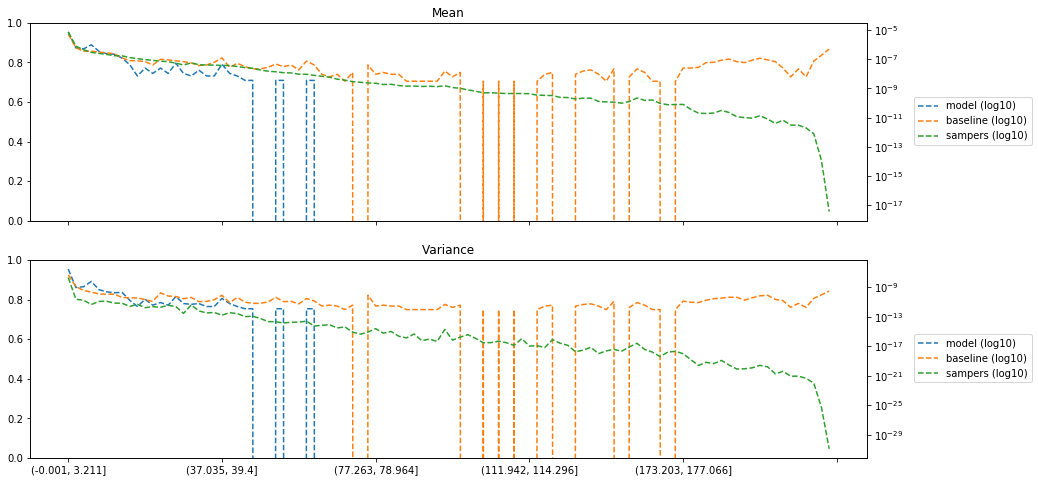

In [157]:
quick_eval("east", converted_visits, converted_baseline, home_locations, sampers)

removed 2878 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 0 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
2948 visits left after alignment
removed 2076 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 731 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
3502 visits left after alignment
9.030147725729004e-15


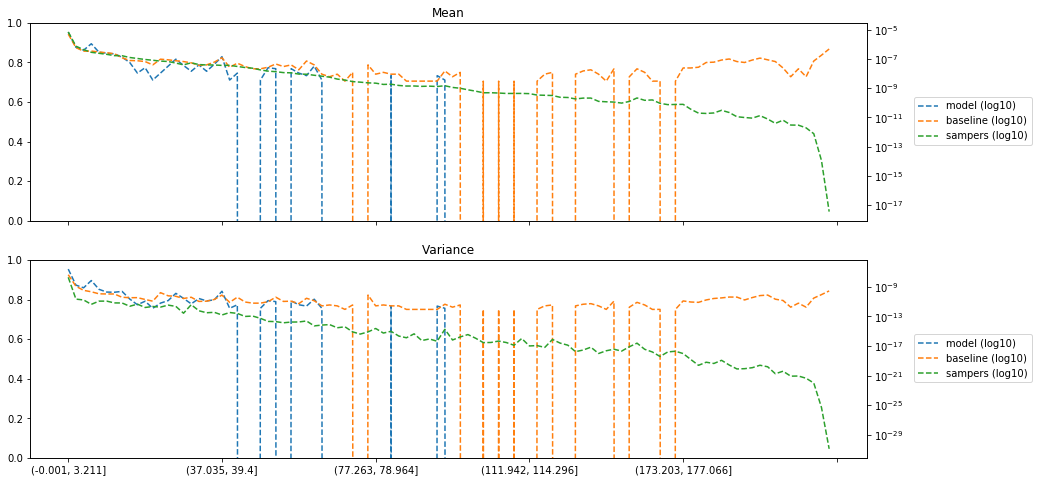

In [161]:
quick_eval("east", converted_visits, converted_baseline, home_locations, sampers)

removed 49391 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 0 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
69111 visits left after alignment
removed 32182 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 9085 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
47048 visits left after alignment
3.618724843303568e-15


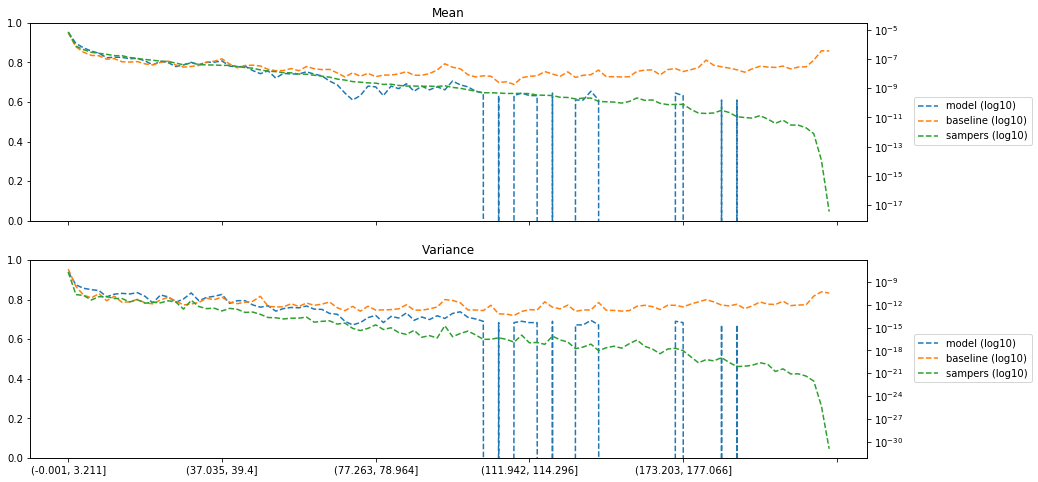

In [168]:
quick_eval("east", converted_visits, converted_baseline, home_locations, sampers)

removed 1200207 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 28 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
1095637 visits left after alignment
removed 670445 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 82836 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
536139 visits left after alignment
8.306993347209306e-16


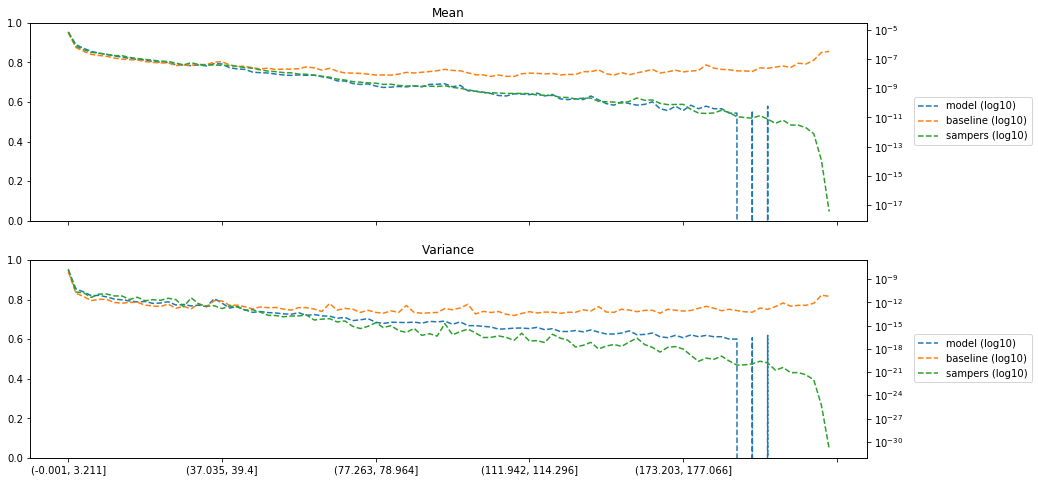

In [178]:
quick_eval("east", converted_visits, converted_baseline, home_locations, sampers)

## West

removed 101701 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 12 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
16789 visits left after alignment
removed 79434 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 2175 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
6706 visits left after alignment
8.5338932525916e-15


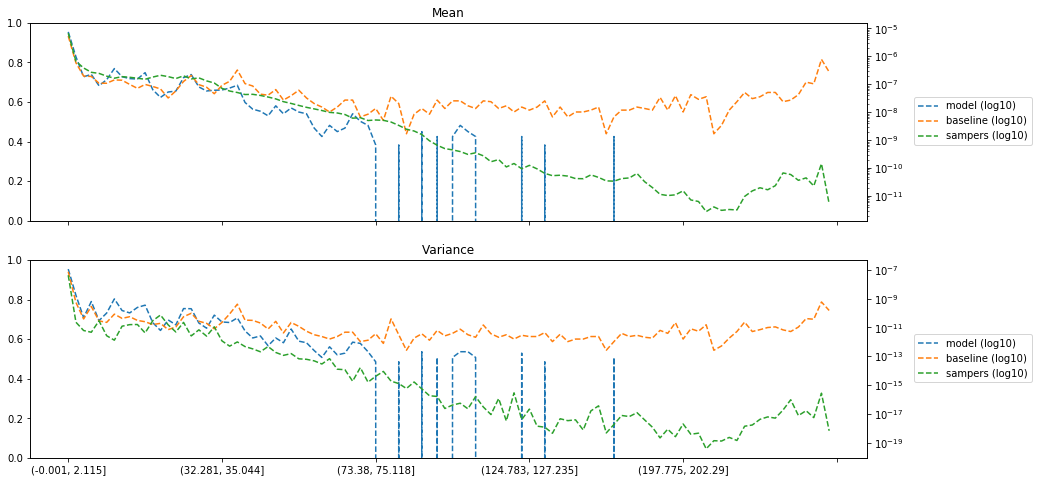

In [169]:
quick_eval("west", converted_visits, converted_baseline, home_locations, sampers)

removed 1866511 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 273 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
429088 visits left after alignment
removed 1046764 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 27187 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
215469 visits left after alignment
1.6193506267838702e-15


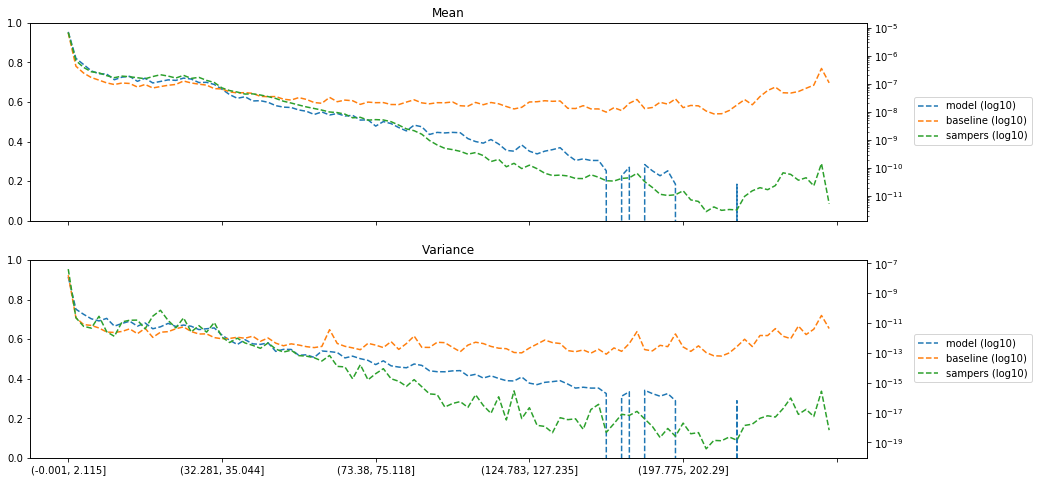

In [179]:
quick_eval("west", converted_visits, converted_baseline, home_locations, sampers)

In [182]:
visits.to_csv('./../../dbs/sweden/visits-transition-mx.csv')